Mounted at /content/drive


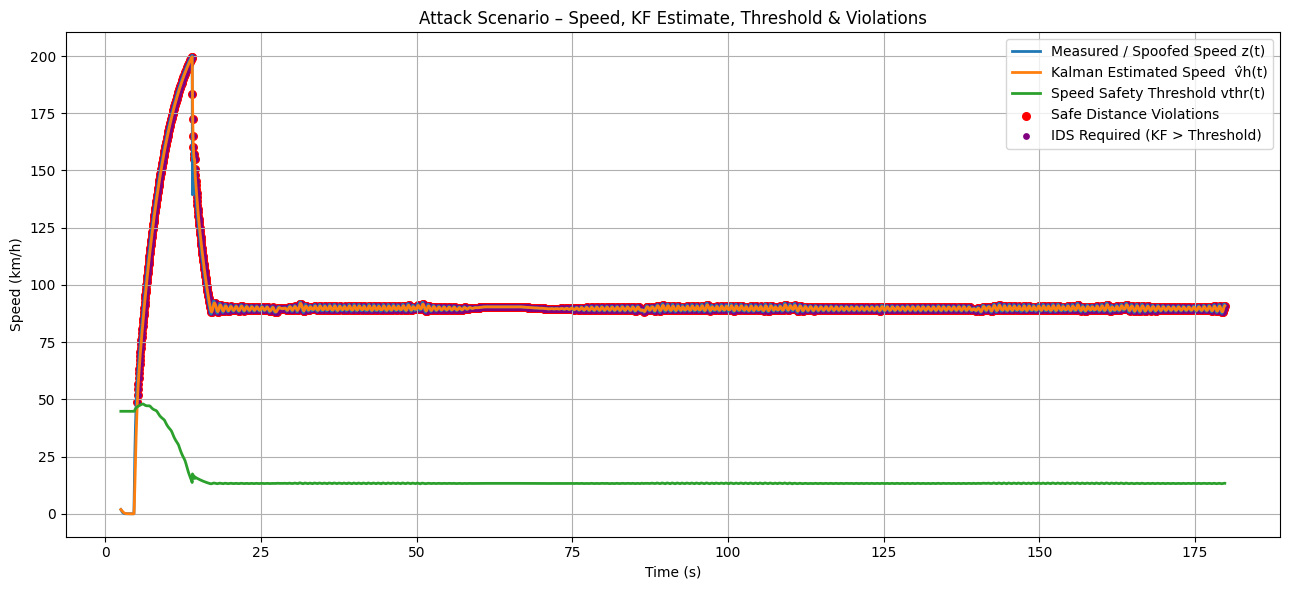

In [1]:
# ============================================================
# ATTACK ONLY — Plot Speed, KF, Threshold + Violation Markers
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------------
# Paper Parameters (Eq. 8)
# -------------------------------
HEADWAY = 2.0
A_DECEL = 3.4     # m/s^2
DT = 0.05         # approximate timestep if not explicitly given

DATA_PATH = "/content/drive/MyDrive/acc"
attack_file = "acc20220924-152419.csv"   # <-- Attack dataset

# -------------------------------
# Kalman Filter (Section 2.1)
# -------------------------------
def kalman_filter(z, Q=0.05, R=0.5):
    n = len(z)
    x = np.zeros(n)
    P = np.zeros(n)

    x[0] = z[0]
    P[0] = 1.0

    for t in range(1, n):
        x_pred = x[t-1]
        P_pred = P[t-1] + Q

        K = P_pred / (P_pred + R)

        x[t] = x_pred + K * (z[t] - x_pred)
        P[t] = (1 - K) * P_pred

    return x

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_csv(os.path.join(DATA_PATH, attack_file))

t = df["timestamp"].values

vh_meas = df["ego_vehicle_v"].values * 3.6
vh_kf = kalman_filter(vh_meas)

ego = df[["ego_vehicle_x","ego_vehicle_y","ego_vehicle_z"]].values
lead = df[["leader_vehicle_x","leader_vehicle_y","leader_vehicle_z"]].values
gap = np.linalg.norm(lead - ego, axis=1)

vl = df["leader_vehicle_v"].values * 3.6

# ------------------------------------------
# Safe Distance (Paper Eq. 8)
# ------------------------------------------
dsafe = 0.278 * HEADWAY * vh_kf + 0.039 * (vh_kf**2) / A_DECEL

# ------------------------------------------
# Lemma 4.1: Compute vthr(t)
# ------------------------------------------
# vthr =
#   (a/0.078)[ -(0.278h+Δt) + sqrt((0.278h+Δt)^2 + (0.156/a)(d + vl Δt)) ]

term = (0.278*HEADWAY + DT)
inner = term**2 + (0.156/A_DECEL) * (gap + vl*DT)
vthr = (A_DECEL / 0.078) * (-term + np.sqrt(inner))

# ------------------------------------------
# Violations: when gap < dsafe
# ------------------------------------------
violation = gap < dsafe

# ------------------------------------------
# IDS Meaning (Section 5):
# IDS should trigger when KF-estimated speed crosses vthr
# ------------------------------------------
ids_trigger = vh_kf > vthr

# -------------------------------
# PLOT
# -------------------------------
plt.figure(figsize=(13,6))

plt.plot(t, vh_meas, label="Measured / Spoofed Speed z(t)", linewidth=2)
plt.plot(t, vh_kf, label="Kalman Estimated Speed  v̂h(t)", linewidth=2)
plt.plot(t, vthr, label="Speed Safety Threshold vthr(t)", linewidth=2)

# Mark violation points
plt.scatter(t[violation], vh_kf[violation],
            color="red", s=30,
            label="Safe Distance Violations")

# Mark IDS trigger concept points
plt.scatter(t[ids_trigger], vh_kf[ids_trigger],
            color="purple", s=15,
            label="IDS Required (KF > Threshold)")

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Attack Scenario – Speed, KF Estimate, Threshold & Violations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


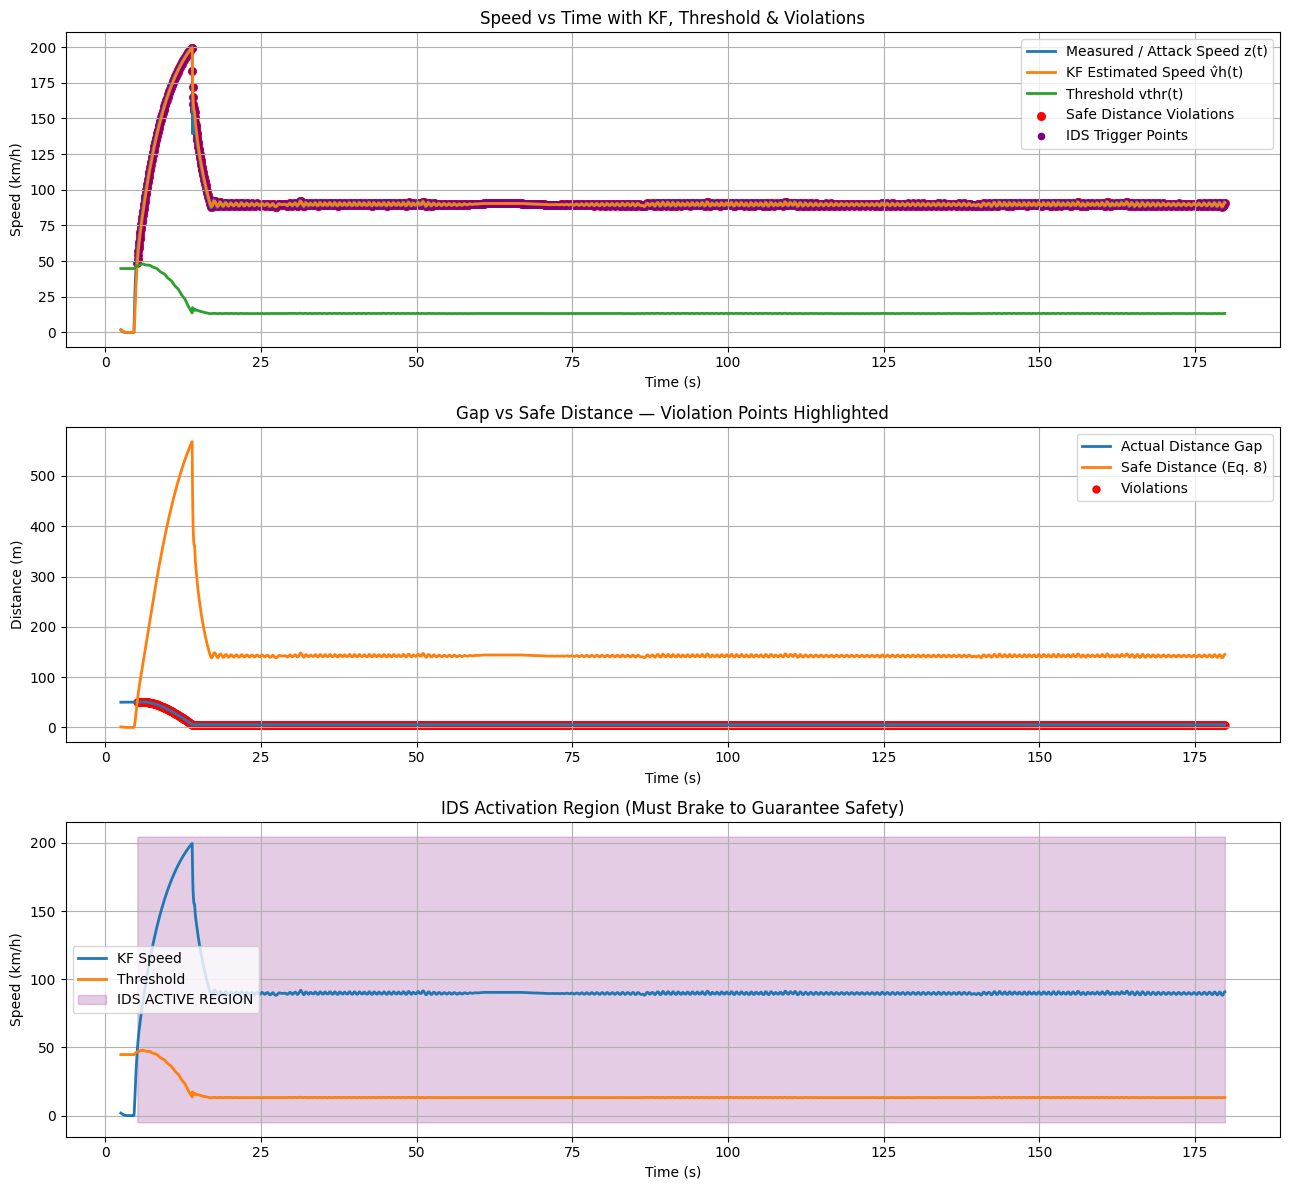

In [2]:
# ============================================================
# FINAL ATTACK ANALYSIS FIGURE
# KF • Threshold • Safe Distance • IDS Activation
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------------
# Paper Parameters
# -------------------------------
HEADWAY = 2.0
A_DECEL = 3.4
DT = 0.05

DATA_PATH = "/content/drive/MyDrive/acc"
attack_file = "acc20220924-152419.csv"   # attack dataset

# -------------------------------
# Kalman Filter
# -------------------------------
def kalman_filter(z, Q=0.05, R=0.5):
    n = len(z)
    x = np.zeros(n)
    P = np.zeros(n)

    x[0] = z[0]
    P[0] = 1.0

    for t in range(1, n):
        x_pred = x[t-1]
        P_pred = P[t-1] + Q
        K = P_pred / (P_pred + R)
        x[t] = x_pred + K * (z[t] - x_pred)
        P[t] = (1 - K) * P_pred

    return x

# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv(os.path.join(DATA_PATH, attack_file))

t = df["timestamp"].values
vh_meas = df["ego_vehicle_v"].values * 3.6
vh_kf = kalman_filter(vh_meas)

ego = df[["ego_vehicle_x","ego_vehicle_y","ego_vehicle_z"]].values
lead = df[["leader_vehicle_x","leader_vehicle_y","leader_vehicle_z"]].values
gap = np.linalg.norm(lead - ego, axis=1)

vl = df["leader_vehicle_v"].values * 3.6

# -------------------------------
# Safe Distance (Eq. 8)
# -------------------------------
dsafe = 0.278 * HEADWAY * vh_kf + 0.039 * (vh_kf**2) / A_DECEL

# -------------------------------
# Threshold from Lemma 4.1
# -------------------------------
term = (0.278*HEADWAY + DT)
inner = term**2 + (0.156/A_DECEL) * (gap + vl*DT)
vthr = (A_DECEL / 0.078) * (-term + np.sqrt(inner))

# -------------------------------
# Conditions
# -------------------------------
violation = gap < dsafe
ids_trigger = vh_kf > vthr

# For visualization: keep IDS ON after first trigger
ids_active = np.zeros_like(ids_trigger, dtype=bool)
triggered = False
for i in range(len(ids_trigger)):
    if ids_trigger[i]:
        triggered = True
    if triggered:
        ids_active[i] = True

# ============================================================
# PLOT
# ============================================================
fig, axes = plt.subplots(3, 1, figsize=(13, 12))
ax1, ax2, ax3 = axes

# -------- PANEL 1: SPEED + KF + THRESHOLD --------
ax1.plot(t, vh_meas, label="Measured / Attack Speed z(t)", linewidth=2)
ax1.plot(t, vh_kf, label="KF Estimated Speed v̂h(t)", linewidth=2)
ax1.plot(t, vthr, label="Threshold vthr(t)", linewidth=2)

ax1.scatter(t[violation], vh_kf[violation],
            color="red", s=30, label="Safe Distance Violations")

ax1.scatter(t[ids_trigger], vh_kf[ids_trigger],
            color="purple", s=20, label="IDS Trigger Points")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Speed (km/h)")
ax1.set_title("Speed vs Time with KF, Threshold & Violations")
ax1.grid(True)
ax1.legend()

# -------- PANEL 2: GAP vs SAFE DISTANCE --------
ax2.plot(t, gap, label="Actual Distance Gap", linewidth=2)
ax2.plot(t, dsafe, label="Safe Distance (Eq. 8)", linewidth=2)
ax2.scatter(t[violation], gap[violation], color="red", s=25, label="Violations")

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Distance (m)")
ax2.set_title("Gap vs Safe Distance — Violation Points Highlighted")
ax2.grid(True)
ax2.legend()

# -------- PANEL 3: IDS ACTIVATION TIMELINE --------
ax3.plot(t, vh_kf, label="KF Speed", linewidth=2)
ax3.plot(t, vthr, label="Threshold", linewidth=2)

ax3.fill_between(t, min(vh_kf)-5, max(vh_kf)+5,
                 where=ids_active,
                 color="purple", alpha=0.2,
                 label="IDS ACTIVE REGION")

ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (km/h)")
ax3.set_title("IDS Activation Region (Must Brake to Guarantee Safety)")
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

# OPTIONAL: Save publication-quality figure
fig.savefig("/content/drive/MyDrive/attack_ids_final_plot.pdf", dpi=400)
